# Intro
Borrowed code from Keras U-Net starter to implement in PyTorch.

The architecture used is the so-called [U-Net](https://arxiv.org/abs/1505.04597), which is very common for image segmentation problems such as this. I believe they also have a tendency to work quite well even on small datasets.

Let's get started importing everything we need!

In [3]:
import os
import sys
import random
import warnings

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from PIL import Image, ImageEnhance

from tqdm import tqdm
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

import torch
import torch.nn as nn
from torch.autograd import Variable
from torchvision import transforms

# Set some parameters
IMG_CHANNELS = 3
TRAIN_PATH = 'input/stage1_train/'
TEST_PATH = 'input/stage1_test/'

warnings.filterwarnings('ignore', category=UserWarning, module='skimage')
seed = 42
random.seed = seed
np.random.seed = seed

In [4]:
# Get train and test IDs
train_ids = next(os.walk(TRAIN_PATH))[1]
test_ids = next(os.walk(TEST_PATH))[1]

# Get the data
Let's first import all the images and associated masks. I downsample both the training and test images to keep things light and manageable, but we need to keep a record of the original sizes of the test images to upsample our predicted masks and create correct run-length encodings later on. There are definitely better ways to handle this, but it works fine for now!

In [147]:
# Get and resize train images and masks
X_train = []
Y_train = []
mask_counts = []
mask_sizes = []
print('Getting and resizing train images and masks ... ')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
    path = TRAIN_PATH + id_
    img = Image.fromarray(imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS])
    w, h = img.size
    X_train.append(img)
    mask = np.zeros((h, w), dtype=np.uint8)
    mask_count = 0
    for mask_file in next(os.walk(path + '/masks/'))[2]:
        mask_ = imread(path + '/masks/' + mask_file)
        mask = np.maximum(mask, mask_)
        mask_count += 1
        mask_sizes.append(mask_.sum())
    Y_train.append(Image.fromarray(mask))
    mask_counts.append(mask_count)
# Get and resize test images
X_test = []
sizes_test = []
print('Getting and resizing test images ... ')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
    path = TEST_PATH + id_
    img = Image.open(path + '/images/' + id_ + '.png')
    sizes_test.append([img.size[0], img.size[1]])
    X_test.append(img)

print('Done!')

Getting and resizing train images and masks ... 


100%|██████████| 670/670 [01:21<00:00, 19.96it/s]

Getting and resizing test images ... 



100%|██████████| 65/65 [00:00<00:00, 13521.96it/s]

Done!


In [134]:
mask_sizes_hist = np.histogram(mask_sizes, bins=100)

In [146]:
256*256

65536

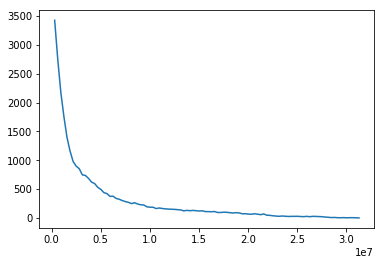

In [144]:
plt.plot(mask_sizes_hist[1][1:], mask_sizes_hist[0])

Define some transformations.  Need them to be able to hold their parameters for both the image and the mask.

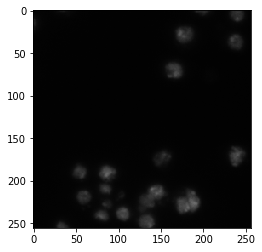

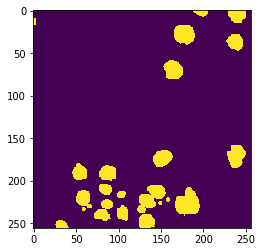

375


In [54]:
plt.imshow(X_train[0])
plt.show()
plt.imshow(np.asarray(Y_train[0]))
plt.show()
print(max(mask_counts))

In [7]:
# create random crop class that holds parameters until called to switch
class RandomCrop(object):
    def __init__(self, size):
        self.size = size
        self.i = 0
        self.j = 0
        
    def gen_params(self, img_size):
        if self.size >= img_size:
            self.i = 0
            self.j = 0
        else:
            self.i = random.randint(0, img_size-self.size)
            self.j = random.randint(0, img_size-self.size)
    
    def __call__(self, img):
        return img.crop((self.i, self.j, self.i+self.size, self.j+self.size))

In [42]:
class RandomRotateAndFlip(object):
    def __init__(self, max_angle):
        self.max_angle = max_angle
        self.angle = None
        self.flip_horizontal = False
        self.flip_vertical = False
        
    def gen_params(self):
        self.angle = np.random.uniform(-self.max_angle, self.max_angle)
        if np.random.uniform() < 0.5:
            self.flip_horizontal = True
        else:
            self.flip_horizontal = False
        if np.random.uniform() < 0.5:
            self.flip_vertical = True
        else:
            self.flip_vertical = False
        
        
    def __call__(self, img):
        if self.angle is None:
            self.gen_params()
        return_img = img.rotate(self.angle, False, False, None)
        if self.flip_horizontal:
            return_img = return_img.transpose(Image.FLIP_LEFT_RIGHT)
        if self.flip_vertical:
            return_img = return_img.transpose(Image.FLIP_TOP_BOTTOM)
        return return_img

In [43]:
class RandomColorJitter(object):
    def __init__(self, brightness=0.1, contrast=0.1, saturation=0.1):
        self.brightness = brightness
        self.contrast = contrast
        self.saturation = saturation
        self.brightness_factor = None
        self.contrast_factor = None
        self.saturation_factor = None
    
    def gen_params(self):
        self.brightness_factor = np.random.uniform(max(0, 1.0-self.brightness), 1.0+self.brightness)
        self.contrast_factor = np.random.uniform(max(0, 1.0-self.contrast), 1.0+self.contrast)
        self.saturation_factor = np.random.uniform(max(0, 1.0-self.saturation), 1.0+self.saturation)
        
    def __call__(self, img):
        if self.brightness_factor is None:
            self.gen_params()
        brightness_enhancer = ImageEnhance.Brightness(img)
        return_img = brightness_enhancer.enhance(self.brightness_factor)
        contrast_enhancer = ImageEnhance.Contrast(return_img)
        return_img = contrast_enhancer.enhance(self.contrast_factor)
        color_enhancer = ImageEnhance.Color(return_img)
        return_img = color_enhancer.enhance(self.saturation_factor)
        return return_img

In [49]:
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms

img_size = 128
class NucleusDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
        self.crop = RandomCrop(112)
        self.rot_flip = RandomRotateAndFlip(180)
        self.jitter_factor = 0.2
        self.color_jitter = RandomColorJitter(self.jitter_factor, 
                                              self.jitter_factor, 
                                              self.jitter_factor)
        self.X_transforms = transforms.Compose([transforms.Scale(img_size),
                                                #self.crop, 
                                                self.rot_flip, 
                                                #self.color_jitter, 
                                                transforms.ToTensor(),
                                                #transforms.Normalize((0.5, 0.5, 0.5), 
                                                #                     (0.5, 0.5, 0.5))
                                               ])
        self.Y_transforms = transforms.Compose([transforms.Scale(img_size),
                                                #self.crop, 
                                                self.rot_flip, 
                                                transforms.ToTensor()])

    def __getitem__(self, index):
        self.gen_params(img_size)
        return {'X': self.X_transforms(self.X[index]), 
                'y': self.Y_transforms(self.y[index])}
    
    def __len__(self):
        return len(self.X)
    
    def gen_params(self, img_size):
        self.crop.gen_params(img_size)
        self.rot_flip.gen_params()
        self.color_jitter.gen_params()

In [50]:
train_dataset = NucleusDataset(X_train, Y_train)
train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True)

In [51]:
def unnorm(x):
    un_x = 255*(x*0.5+0.5)
    return un_x.astype(np.uint8)

gen_params
call
call


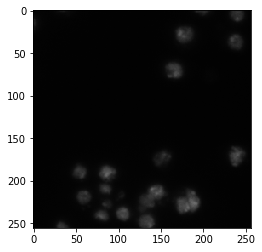

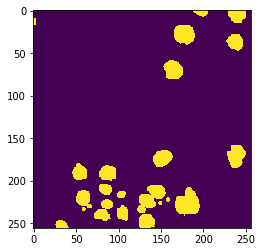

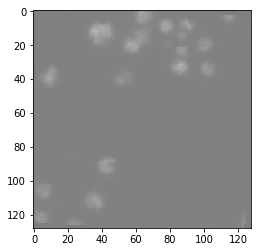

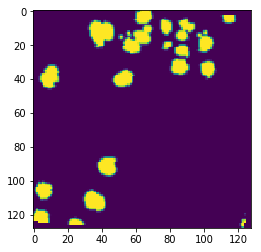

In [52]:
# Check if training data looks all right
#ix = random.randint(0, len(train_dataset))
ix = 0
sample = train_dataset[ix]
X_train_sample = sample['X']
Y_train_sample = sample['y']
plt.imshow(X_train[ix])
plt.show()
plt.imshow(np.asarray(Y_train[ix]))
plt.show()
plt.imshow(unnorm(X_train_sample.numpy().transpose(1,2,0)))
plt.show()
plt.imshow(Y_train_sample.numpy()[0])
plt.show()

# Build and train our neural network
Next we build our U-Net model, loosely based on [U-Net: Convolutional Networks for Biomedical Image Segmentation](https://arxiv.org/pdf/1505.04597.pdf) and very similar to [this repo](https://github.com/jocicmarko/ultrasound-nerve-segmentation) from the Kaggle Ultrasound Nerve Segmentation competition.

![](https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/u-net-architecture.png)

In [38]:
# Build U-Net model
class DownBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3):
        super(DownBlock, self).__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size, padding=0),
            nn.ReflectionPad2d(kernel_size//2),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(True),
            nn.Conv2d(out_channels, out_channels, kernel_size, padding=0),
            nn.ReflectionPad2d(kernel_size//2),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(True)
        )
    
    def forward(self, x):
        c = self.block(x)
        return c

class UpBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=2, stride=2):
        super(UpBlock, self).__init__()
        self.up = nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding=0)
        self.conv = DownBlock(2*out_channels, out_channels)
    
    def forward(self, x1, x2):
        x = torch.cat([self.up(x1), x2], dim=1)
        return self.conv(x)
        
class UNet(nn.Module):
    def __init__(self, n_channels, n_classes):
        super(UNet, self).__init__()
        self.dblock1 = DownBlock(n_channels, 64)
        self.pool1 = nn.MaxPool2d(2, stride=2, ceil_mode=True)
        self.dblock2 = DownBlock(64, 128)
        self.pool2 = nn.MaxPool2d(2, stride=2, ceil_mode=True)
        self.dblock3 = DownBlock(128, 256)
        self.pool3 = nn.MaxPool2d(2, stride=2, ceil_mode=True)
        self.dblock4 = DownBlock(256, 512)
        self.pool4 = nn.MaxPool2d(2, stride=2, ceil_mode=True)
        self.dblock5 = DownBlock(512, 1024)
        self.ublock5 = UpBlock(1024, 512)
        self.ublock4 = UpBlock(512, 256)
        self.ublock3 = UpBlock(256, 128)
        self.ublock2 = UpBlock(128, 64)
        self.output = nn.Conv2d(64, n_classes, kernel_size=1, groups=1, stride=1)
        
    def forward(self, x):
        c1 = self.dblock1(x)
        p1 = self.pool1(c1)
        c2 = self.dblock2(p1)
        p2 = self.pool1(c2)
        c3 = self.dblock3(p2)
        p3 = self.pool1(c3)
        c4 = self.dblock4(p3)
        p4 = self.pool1(c4)
        c5 = self.dblock5(p4)
        u5 = self.ublock5(c5, c4)
        u4 = self.ublock4(u5, c3)
        u3 = self.ublock3(u4, c2)
        u2 = self.ublock2(u3, c1)

        return self.output(u2)

In [39]:
model = UNet(3, 2)

In [40]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

In [41]:
def recon_loss(output, mask):
    probs = nn.Sigmoid()(output)
    intersection = torch.sum(probs[:,1,:,:]*mask.squeeze(1))
    return 1.0 - ((2.0*intersection+1.0)/(torch.sum(probs[:,1,:,:]) + torch.sum(mask) + 1.0))

In [42]:
n_epochs = 30
for _ in tqdm(range(n_epochs)):
    for data in train_dataloader:
        optimizer.zero_grad()
        X = Variable(data['X'])
        target = Variable(data['y'])
        output = model(X)
        loss = recon_loss(output, target)
        print("loss: " + str(loss.data.numpy()[0]))
        loss.backward()
        optimizer.step()


  0%|          | 0/30 [00:00<?, ?it/s]


loss: 0.8376429
loss: 0.7837669
loss: 0.8046831
loss: 0.7015689
loss: 0.8264271
loss: 0.6818615
loss: 0.6948967
loss: 0.7433039
loss: 0.86274177
loss: 0.84980184
loss: 0.75441015
loss: 0.61562103
loss: 0.6475035
loss: 0.76855916
loss: 0.756196
loss: 0.754006
loss: 0.90535575
loss: 0.80086356
loss: 0.929636
loss: 0.7947747
loss: 0.92611253
loss: 0.8078059
loss: 0.8733214
loss: 0.8594793
loss: 0.79911536
loss: 0.82940847
loss: 0.8241956
loss: 0.7380117
loss: 0.91435206
loss: 0.7458494
loss: 0.6854248
loss: 0.79372007
loss: 0.8609029
loss: 0.7241658
loss: 0.8369084
loss: 0.7921518
loss: 0.84146655
loss: 0.65679103
loss: 0.7441887
loss: 0.8229792
loss: 0.78030014
loss: 0.75882554
loss: 0.7575981
loss: 0.8893007
loss: 0.6823485
loss: 0.7989309
loss: 0.75814146
loss: 0.83214724
loss: 0.7557324
loss: 0.755728
loss: 0.8275427
loss: 0.7959476
loss: 0.7376236
loss: 0.7856986
loss: 0.8734446
loss: 0.7198408
loss: 0.87878656
loss: 0.8274062
loss: 0.7172917
loss: 0.73868597
loss: 0.7706562
loss: 0.

  3%|▎         | 1/30 [10:39<5:08:51, 639.03s/it]

loss: 0.807024
loss: 0.75884295
loss: 0.7808777
loss: 0.6988694
loss: 0.7551134
loss: 0.76949155
loss: 0.75941527
loss: 0.71899015
loss: 0.7249895
loss: 0.82796973
loss: 0.7900314
loss: 0.7937522
loss: 0.8089385
loss: 0.8131973
loss: 0.7422205
loss: 0.7410871
loss: 0.7667898
loss: 0.80406666
loss: 0.79747903
loss: 0.8244143
loss: 0.73710144
loss: 0.79395247
loss: 0.7634431
loss: 0.8004198
loss: 0.7314055
loss: 0.79373544
loss: 0.78989637
loss: 0.8988552
loss: 0.8479246
loss: 0.78696465
loss: 0.7775108
loss: 0.7080158
loss: 0.7909786
loss: 0.7445874
loss: 0.7291312
loss: 0.7288878
loss: 0.69567835
loss: 0.80052876
loss: 0.75840175
loss: 0.85369396
loss: 0.7588793
loss: 0.7583918
loss: 0.81360584
loss: 0.71783054
loss: 0.78055334
loss: 0.7662826
loss: 0.8313023
loss: 0.8246951
loss: 0.7292118
loss: 0.7633856
loss: 0.8461441
loss: 0.700722
loss: 0.80141896
loss: 0.81024975
loss: 0.7983979
loss: 0.8629146
loss: 0.7231224
loss: 0.79934466
loss: 0.7934864
loss: 0.78149134
loss: 0.7787267
los

  7%|▋         | 2/30 [20:22<4:50:23, 622.28s/it]

loss: 0.76622915
loss: 0.6873653
loss: 0.7338484
loss: 0.79843885
loss: 0.8583054
loss: 0.81724274
loss: 0.78961724
loss: 0.77094334
loss: 0.80366
loss: 0.7906171
loss: 0.86701244
loss: 0.83660084
loss: 0.8211015
loss: 0.79493976
loss: 0.82693076
loss: 0.7883426
loss: 0.79665786
loss: 0.7865888
loss: 0.7592057
loss: 0.7931215
loss: 0.83183944
loss: 0.7568811
loss: 0.6713711
loss: 0.7954106
loss: 0.8002867
loss: 0.7637327
loss: 0.9549833
loss: 0.839554
loss: 0.8545112
loss: 0.77335554
loss: 0.7697409
loss: 0.7600385


KeyboardInterrupt: 

All right, looks good! Loss seems to be a bit erratic, though. I'll leave it to you to improve the model architecture and parameters! 

# Make predictions

Let's make predictions both on the test set, the val set and the train set (as a sanity check). Remember to load the best saved model if you've used early stopping and checkpointing.

In [ ]:
# Predict on train, val and test
#model = load_model('../models/dsbowl2018-1.h5')
preds_train = model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=1)
preds_val = model.predict(X_train[int(X_train.shape[0]*0.9):], verbose=1)
preds_test = model.predict(X_test, verbose=1)

# Threshold predictions
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)

# Create list of upsampled test masks
preds_test_upsampled = []
for i in range(len(preds_test)):
    preds_test_upsampled.append(resize(np.squeeze(preds_test[i]), 
                                       (sizes_test[i][0], sizes_test[i][1]), 
                                       mode='constant', preserve_range=True))

In [ ]:
# Perform a sanity check on some random training samples
ix = random.randint(0, len(preds_train_t))
imshow(X_train[ix])
plt.show()
imshow(np.squeeze(Y_train[ix]))
plt.show()
imshow(np.squeeze(preds_train_t[ix]))
plt.show()

The model is at least able to fit to the training data! Certainly a lot of room for improvement even here, but a decent start. How about the validation data?

In [ ]:
# Perform a sanity check on some random validation samples
ix = random.randint(0, len(preds_val_t))
imshow(X_train[int(X_train.shape[0]*0.9):][ix])
plt.show()
imshow(np.squeeze(Y_train[int(Y_train.shape[0]*0.9):][ix]))
plt.show()
imshow(np.squeeze(preds_val_t[ix]))
plt.show()

Not too shabby! Definitely needs some more training and tweaking.

# Encode and submit our results

Now it's time to submit our results. I've stolen [this](https://www.kaggle.com/rakhlin/fast-run-length-encoding-python) excellent implementation of run-length encoding.

In [67]:
# Run-length encoding stolen from https://www.kaggle.com/rakhlin/fast-run-length-encoding-python
def rle_encoding(x):
    dots = np.where(x.T.flatten() == 1)[0]
    run_lengths = []
    prev = -2
    for b in dots:
        if (b>prev+1): run_lengths.extend((b + 1, 0))
        run_lengths[-1] += 1
        prev = b
    return run_lengths

def prob_to_rles(x, cutoff=0.5):
    lab_img = label(x > cutoff)
    for i in range(1, lab_img.max() + 1):
        yield rle_encoding(lab_img == i)

In [61]:
lab = label(np.asarray(Y_train[0]) > 0.5)
print(lab.shape)
print(lab.max())
print(lab.min())

(256, 256)
23
0


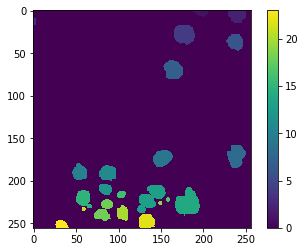

In [60]:
plt.imshow(lab)
plt.colorbar()
plt.show()

In [71]:
labs = [np.copy(lab) for _ in range(lab.max())]
for i in range(1, lab.max()):
    labs[i][labs[i] < i] = 0
    labs[i][labs[i] > i] = 0
    labs[i][labs[i] > 0] = 1
labs = np.array(labs)

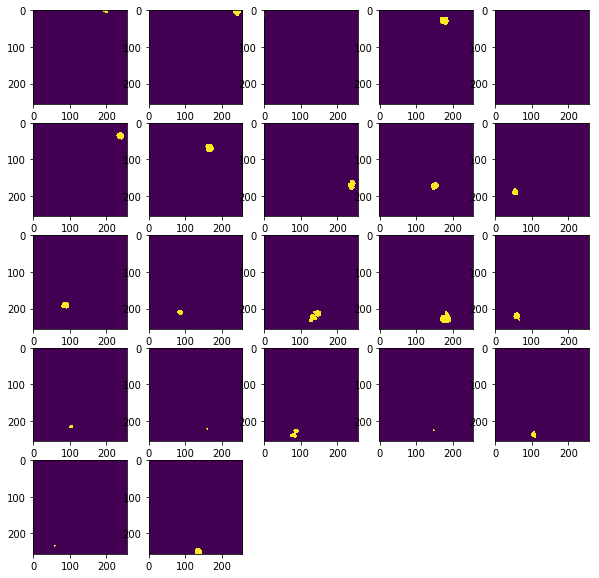

In [78]:
plt.figure(figsize=(10,10))
for i in range(1, 23):
    plt.subplot(5, 5, i)
    plt.imshow(labs[i])
plt.show()

In [96]:
def dist(x0, x1):
    return np.linalg.norm(np.array(x1)-np.array(x0))

In [126]:
%matplotlib inline

def plot_label(label):
    lab_0 = label
    nonzero_loc = np.argwhere(lab_0>0)
    centroid_x = np.sum(nonzero_loc[:,1])/len(nonzero_loc)
    centroid_y = np.sum(nonzero_loc[:,0])/len(nonzero_loc)
    dists = []
    l = len(lab_0)
    for i in range(l):
        for j in range(l):
            if lab_0[i][j] > 0.5:
                dists.append(dist((i,j), (centroid_y,centroid_x)))
    dists = np.array(dists)
    plt.hist(dists, bins=20)

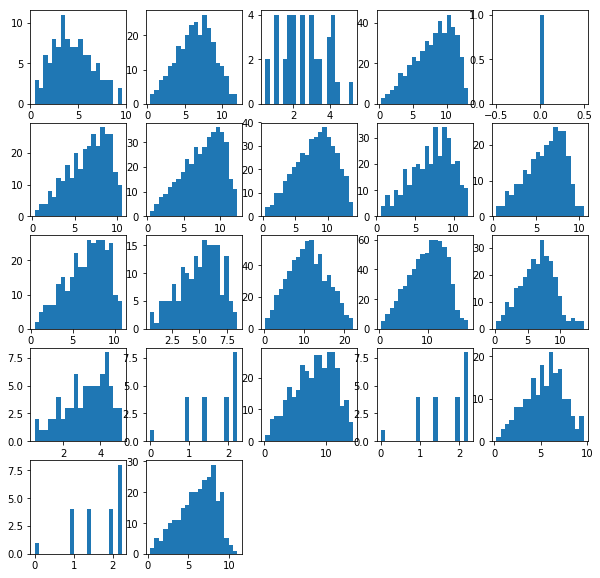

In [129]:
plt.figure(figsize=(10,10))
for i in range(1, len(labs)):
    plt.subplot(5, 5, i)
    plot_label(labs[i])

In [79]:
rle = list(prob_to_rles(np.asarray(Y_train[0]), 0.5))
print(len(rle))

23


Let's iterate over the test IDs and generate run-length encodings for each seperate mask identified by skimage ...

In [ ]:
new_test_ids = []
rles = []
for n, id_ in enumerate(test_ids):
    rle = list(prob_to_rles(preds_test_upsampled[n]))
    rles.extend(rle)
    new_test_ids.extend([id_] * len(rle))

... and then finally create our submission!

In [ ]:
# Create submission DataFrame
sub = pd.DataFrame()
sub['ImageId'] = new_test_ids
sub['EncodedPixels'] = pd.Series(rles).apply(lambda x: ' '.join(str(y) for y in x))
sub.to_csv('sub-dsbowl2018-1.csv', index=False)

This scored 0.233 on the LB for me. That was with version 2 of this notebook; be aware that the results from the neural network are extremely erratic and vary greatly from run to run (version 3 is significantly worse, for example).

You should easily be able to stabilize and improve the results just by changing a few parameters, tweaking the architecture a little bit and training longer with early stopping.

**Have fun!**